In [1]:
import numpy as onp
import matplotlib.pyplot as plt

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap, vjp, jacfwd
from jax import random
from jax.example_libraries import optimizers
from jax.nn import relu, elu
from jax import lax
from torch.utils import data
from functools import partial
import itertools
from tqdm import trange, tqdm
import pickle
import time

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/My Drive/Colab Notebooks/SRS-Net/Data')

Mounted at /content/drive


In [3]:
# Network structure
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = jnp.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2)

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(jnp.dot(inputs, U1) + b1)
      V = activation(jnp.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(jnp.dot(inputs, W) + b)
          inputs = jnp.multiply(outputs, U) + jnp.multiply(1 - outputs, V)  # whats this?
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

$$ \frac {dI_ {s}}{d{z}} =  g_ {R}  I_ {p} I_ {S} - \alpha _ {s}  I_ {s} $$

$$ \frac {dI_ {p}}{d{z}}  = - \frac {\omega_{p}}{\omega_{s}} g_ {R} I_ {p} I_ {s} - \alpha _ {p} I_ {p} $$

In [4]:
# Data generator for labeled data - with paired inputs and outputs
class DataGenerator(data.Dataset):
    def __init__(self, z, p_s, p_p, batch_size=64,
                 rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.z = z
        self.p_s = p_s
        self.p_p = p_p

        self.N = z.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        p_s = self.p_s[idx,:]
        p_p = self.p_p[idx,:]
        z = self.z[idx,:]
        # Construct batch
        inputs = z
        outputs = p_s, p_p
        return inputs, outputs

In [5]:
# Define the model
class PI_SRS:
    def __init__(self, layer_sizes, params=None, lr=1e-3, w_in=1):
      self.nn_init, self.nn_apply = modified_MLP(layer_sizes, activation=jnp.tanh)
      self.w_in = w_in

      if params == None:
        params = self.nn_init(rng_key = random.PRNGKey(1234))
      else:
        params = params

      # Use optimizers to set optimizer initialization and update functions
      self.opt_init, \
      self.opt_update, \
      self.get_params = optimizers.adam(optimizers.exponential_decay(lr,
                                                                    decay_steps=2000,
                                                                    decay_rate=0.9))
      self.opt_state = self.opt_init(params)

      # Loggers
      self.itercount = itertools.count()
      self.loss_log = []
      self.loss_ics_log = []
      self.loss_res_log = []

    def predict(self, params, z):

      spec = self.nn_apply(params, z)

      return spec[0], spec[1]

    # SRS physical law loss
    def res_net(self, params, z):
      Ps, Pp = self.predict(params, z)
      dPs_z, dPp_z = jacfwd(self.predict, argnums=1)(params, z)

      res_ps = dPs_z - dist * gR * Ps * Pp + dist * alpha_s * Ps
      res_pp = dPp_z + dist * omega_p / omega_s *gR * Ps * Pp + dist * alpha_p * Pp

      return res_ps, res_pp

    def loss_signal(self, params, batch):
      z0, outputs = batch
      ps, pp = outputs
      Ps, Pp = vmap(self.predict, (None, 0))(params, z0)
      loss_ps = jnp.mean((Ps - ps) ** 2)
      loss_pp = jnp.mean((Pp - pp) ** 2)

      return loss_ps + loss_pp

    def loss_res(self, params, batch):
      z0, _ = batch
      res_ps, res_pp = vmap(self.res_net, (None, 0))(params, z0)
      loss_resps = jnp.mean(res_ps ** 2)
      loss_respp = jnp.mean(res_pp ** 2)

      return loss_resps + loss_respp

    def loss(self, params, ics_batch, res_batch):
      loss_signal = self.loss_signal(params, ics_batch)
      loss_res = self.loss_res(params, res_batch)

      loss = self.w_in * loss_signal + loss_res
      return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, res_batch):
      params = self.get_params(opt_state)
      g = grad(self.loss)(params, ics_batch, res_batch)
      return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, res_dataset, nIter = 10000):

      ics_data = iter(ics_dataset)
      res_data = iter(res_dataset)

      pbar = trange(nIter)
      # Main training loop
      for i in pbar:
        ics_batch= next(ics_data)
        res_batch = next(res_data)

        self.opt_state = self.step(next(self.itercount), self.opt_state, ics_batch, res_batch)

        if i % 100 == 0:

          params = self.get_params(self.opt_state)

          # Compute losses
          loss_value = self.loss(params, ics_batch, res_batch)
          loss_ics_value = self.loss_signal(params, ics_batch)
          loss_res_value = self.loss_res(params, res_batch)

          # Store losses
          self.loss_log.append(loss_value)
          self.loss_ics_log.append(loss_ics_value)
          self.loss_res_log.append(loss_res_value)

          # Print losses
          pbar.set_postfix({'Loss': loss_value, 'loss_ics' : loss_ics_value, 'loss_physics': loss_res_value})

In [6]:
# Geneate labeled ics training data
def generate_ics_training_data(pz, Psin, Ppin):
    z0 = jnp.zeros((pz, 1))
    ps = jnp.tile(Psin, (pz, 1))
    pp = jnp.tile(Ppin, (pz, 1))

    return z0, ps, pp

# Geneate unlabeled pde res evaluations
def generate_pde_res_training_data(key, pres):
    keys = random.split(key, 2)
    zp = random.uniform(keys[0], (pres, 1))
    p0 = jnp.zeros((pres, 1))

    return zp, p0, p0

In [7]:
# transmission distance (km)
dist = 40
# fiber effective area
Aeff = 10e-13
# Raman gain coefficient
gR = 1e-13 / Aeff
alpha_s = 0.2
alpha_p = 0.2
# signal frequency
omega_s = 193.0
# pump frequency
omega_p = 203.0

In [8]:
# input signal power
Psin = jnp.array([2.0])
# input pump power
Ppin = jnp.array([20.0])
key = random.PRNGKey(0)
pz = 500
pres = 2000

z_train, ps_train, pp_train =  generate_ics_training_data(pz, Psin, Ppin)
z_res, ps_res, pp_res =  generate_pde_res_training_data(key, pres)

In [9]:
ics_dataset = DataGenerator(z_train, ps_train, pp_train, 100)
res_dataset = DataGenerator(z_res, ps_res, pp_res, 2000)

In [ ]:
#  Restore the trained model from saved file
with open('PINN_CW_SRS_1mw_50mw_50km.pkl', 'rb') as f:
     params = pickle.load(f)

In [10]:
layer_sizes = [1, 200, 200, 200, 200, 2]

model = PI_SRS(layer_sizes, params=None, lr=1e-4, w_in=4)

In [11]:
# Train
model.train(ics_dataset, res_dataset, nIter=80000)

100%|██████████| 80000/80000 [08:41<00:00, 153.45it/s, Loss=1.86822e-05, loss_ics=9.9831254e-11, loss_physics=1.86818e-05]


In [12]:
params = model.get_params(model.opt_state)

In [ ]:
# save the trained model
with open('PINN_CW_SRS_1mw_5mw_50km.pkl', 'wb') as f:
    pickle.dump(params, f)

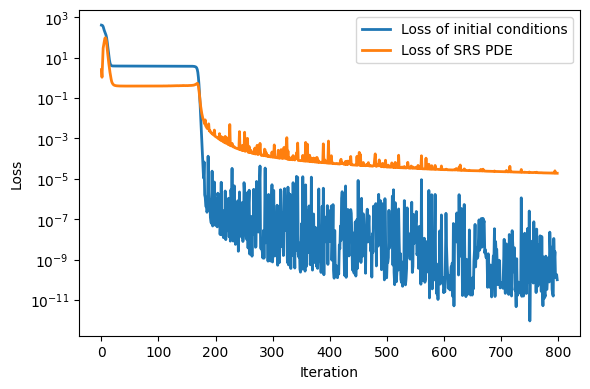

In [13]:
# Plot for loss function
plt.figure(figsize = (6,4))
plt.plot(model.loss_ics_log, lw=2, label='Loss of initial conditions')
plt.plot(model.loss_res_log, lw=2, label='Loss of SRS PDE')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Predict
ind = 1000
dist_batch = jnp.linspace(0, 1, ind)
Ps = vmap(model.predict, (None, 0))(params, dist_batch.reshape(ind, 1))

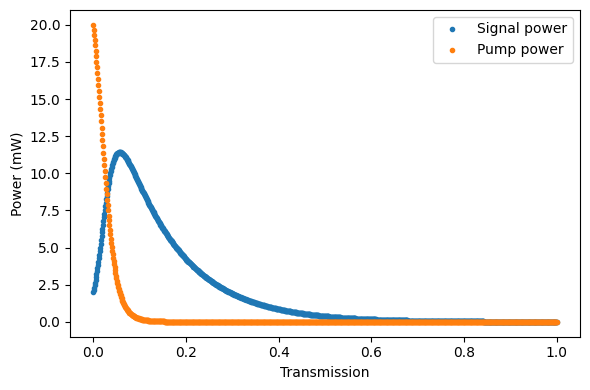

In [15]:
dist = 100
plt.figure(figsize = (6, 4))
plt.plot(dist_batch, Ps[0], '.', label='Signal power')
plt.plot(dist_batch, Ps[1], '.', label='Pump power')
plt.xlabel('Transmission')
plt.ylabel('Power (mW)')
plt.legend()
plt.tight_layout()
plt.show()